In [173]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

Using pandas to clean the natural gas data

In [3]:
file_path = 'raw_data/10yr_gas_data.csv'
# read in csv
df = pd.read_csv(file_path)

In [4]:
dates = []
states = []
values = []

# loop through columns of columns (DC is included so there are 51 state columns)
for i in range(1,52):

   #loop through rows
    for j in range(0,132): 
        date = df.iloc[j,0] # gets date from first column
        dates.append(date)  # adds date to dates list

        state_str = df.columns[i] # gets column title
        state_str = state_str.split(' Natural', 1) #splits the title at the first occurence of the word 'natural'
        state = state_str[0] # saves the state name 
        states.append(state) # adds the state to the states list

        value = df.iloc[j,i] # retrieves the value from the current row,value pair
        values.append(value) # adds the value to the values list 
       



In [5]:
df_clean = pd.DataFrame({
    'Date': dates,
    'State': states,
    'Natural Gas Consumption (MMcf)':values
})

df_clean

,Date,State,Natural Gas Consumption (MMcf)
0,Jan-2010,Alabama,9202.647
1,Feb-2010,Alabama,7762.261
2,Mar-2010,Alabama,6612.051
3,Apr-2010,Alabama,2987.217
4,May-2010,Alabama,1142.784
...,...,...,...
6727,Aug-2020,Wyoming,199.347
6728,Sep-2020,Wyoming,289.642
6729,Oct-2020,Wyoming,567.622
6730,Nov-2020,Wyoming,1532.600


In [6]:
output_path = 'clean_data/natural_gas_data.csv'

df_clean.to_csv(output_path)

Cleaning temperature data

In [7]:
file_path = 'all_states_ave_temp.csv'
# read in csv 
df2 = pd.read_csv(file_path)


In [8]:
df2.head()

,Alabama,Unnamed: 1,Average Temperature,Unnamed: 3
0,Units: Degrees Fahrenheit,NaN,NaN,NaN
1,Base Period: 2010-2020,NaN,NaN,NaN
2,Missing: -99,NaN,NaN,NaN
3,Date,NaN,Value,Anomaly
4,200001,Alabama,46.5,1.6


In [9]:
# drop NaN values from the dataframe
df2.dropna(how='any', inplace=True)

In [10]:
# list of columns to rename
column_names = {
    'Unnamed: 1': 'State', 
    'Average Temperature': 'Avg Temp (F)',
    'Unnamed: 3': 'Anomaly',
    'Alabama' : 'Date'
    }
# renaming columns
df2.rename(columns=column_names, inplace=True)
#reseting index
df2.reset_index(drop=True, inplace=True)
df2.head()

,Date,State,Average Temperature,Anomaly
0,200001,Alabama,46.5,1.6
1,200002,Alabama,52.3,2.5
2,200003,Alabama,58.9,2.7
3,200004,Alabama,60.1,-3.8
4,200005,Alabama,74,2.4


In [11]:
output_path = 'clean_data/avg_temp_by_state.csv'
#output the clean data to csv file
df2.to_csv(output_path)

In [12]:
# file paths
gas_file = 'clean_data/natural_gas_data.csv'
weather_file = 'clean_data/avg_temp_by_state.csv'

# import the files 
weather_df = pd.read_csv(weather_file)
gas_df = pd.read_csv(gas_file)

In [13]:
# droping the extra column that gets added
gas_df.drop(columns='Unnamed: 0', inplace=True)
weather_df.drop(columns='Unnamed: 0', inplace=True)


In [14]:
# drop dates before 2010
weather_df.drop(weather_df.loc[weather_df['Date'] < 201000].index, inplace=True)
weather_df.drop(weather_df.loc[weather_df['Date'] >= 202000].index, inplace=True)

In [15]:
# drop 2020 (since its not in the weather data) as well as DC (for the same reason)
# hawaii also had to be dropped from gas, as the data was not available via noaa
gas_df.drop(gas_df.loc[gas_df['Date'].str.contains("2020")].index, inplace=True)
gas_df.drop(gas_df.loc[gas_df['State']=='District of Columbia'].index, inplace=True)
gas_df.drop(gas_df.loc[gas_df['State']=='Hawaii'].index, inplace=True)
len(gas_df)

5880

In [16]:
out_path_weath = 'output_data/avg_temp_by_state.csv'
out_path_gas = 'output_data/natural_gas_data.csv'


In [17]:
# formatted_df = df["Date"].dt.strftime("%m/%d/%y")

weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%Y%m')

weather_df['Date'] = weather_df['Date'].apply(lambda x: x.strftime('%Y-%m'))

In [18]:
gas_df['Date'] = pd.to_datetime(gas_df['Date'], format='%b-%Y')
gas_df['Date'] = gas_df['Date'].apply(lambda x: x.strftime('%Y-%m'))

In [19]:
gas_df.head()

,Date,State,Natural Gas Consumption (MMcf)
0,2010-01,Alabama,9202.647
1,2010-02,Alabama,7762.261
2,2010-03,Alabama,6612.051
3,2010-04,Alabama,2987.217
4,2010-05,Alabama,1142.784


In [20]:
combined_df = pd.merge(gas_df, weather_df, how='outer')

In [21]:
# drop states that use less than 5000 MMcf per year
combined_df.drop(combined_df.loc[combined_df['Natural Gas Consumption (MMcf)'] <= 5000].index, inplace=True)
combined_df.head()

,Date,State,Natural Gas Consumption (MMcf),Average Temperature,Anomaly
0,2010-01,Alabama,9202.647,40.0,-4.9
1,2010-02,Alabama,7762.261,40.6,-9.2
2,2010-03,Alabama,6612.051,51.2,-5.0
11,2010-12,Alabama,7970.435,40.3,-9.0
12,2011-01,Alabama,9951.178,41.1,-3.8


In [22]:
len(combined_df)

2213

In [23]:
state_df = combined_df.groupby('State').mean()

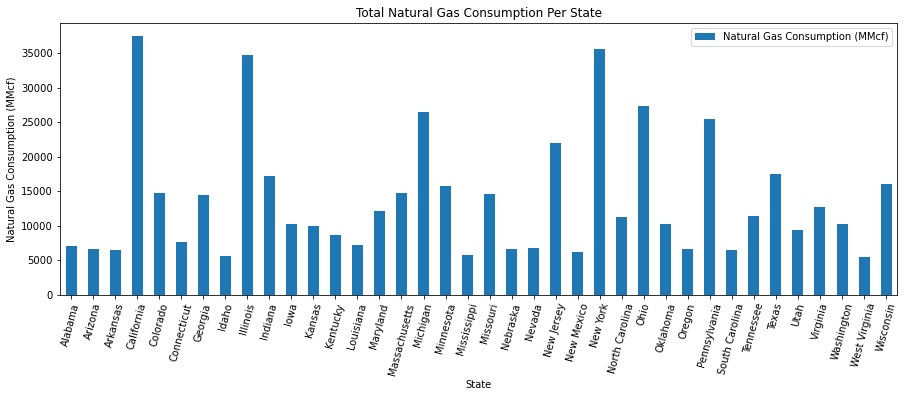

In [215]:
ax1 = state_df.plot(kind='bar', y='Natural Gas Consumption (MMcf)', rot=75, figsize=(15, 5))
ylabel = ax1.set_ylabel('Natural Gas Consumption (MMcf)')
title = ax1.set_title('Total Natural Gas Consumption Per State')
plt.savefig('output_data/total_gas_usage_per_state.png')

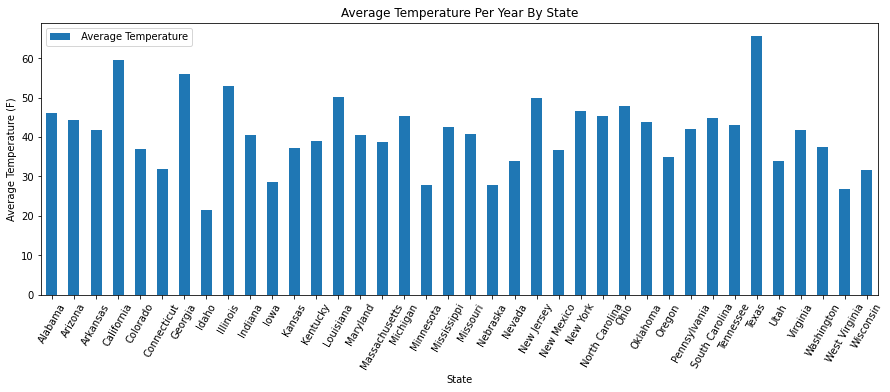

In [216]:
ax1 = state_df.plot(kind='bar', y=' Average Temperature', rot=60, figsize=(15, 5))
ylabel = ax1.set_ylabel('Average Temperature (F)')
title = ax1.set_title('Average Temperature Per Year By State')
plt.savefig('output_data/avg_temp_per_state.png')

In [27]:
cali_data = combined_df.loc[combined_df['State'] == 'California']



<AxesSubplot:label='0a94b513-eec7-44bb-8ae8-0e125453968a', xlabel='Date'>

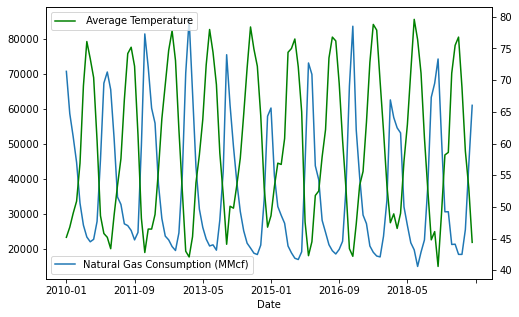

In [28]:
# ax1 = df1.plot()

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
# df2.plot(ax=ax2)

ax1 = cali_data.plot(kind='line', x='Date', y='Natural Gas Consumption (MMcf)')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
cali_data.plot(ax=ax2, x= 'Date', y= ' Average Temperature', color='green', figsize=(8,5))

# Graphs to complete

1. Comparing various states from different reigons
2. look at gas usage per person (gas usage / population)
3. which state has the most extremes temperature wise
4. look at stable temperature states
5. avg temp total versus gas usage total


<AxesSubplot:xlabel=' Average Temperature', ylabel='Natural Gas Consumption (MMcf)'>

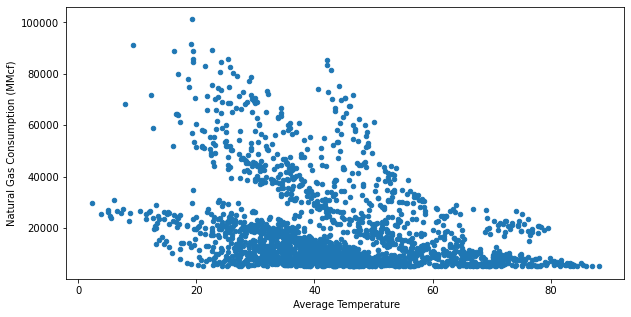

In [29]:
combined_df.plot(kind='scatter', x=' Average Temperature', y='Natural Gas Consumption (MMcf)', figsize=(10, 5))

In [42]:
pop_file = 'clean_data/10yr_population_data.csv'

pop_df = pd.read_csv(pop_file)

In [43]:
pop_df.head()
pop_df.drop(columns='Unnamed: 0', inplace=True)

In [44]:
# loops through and removes '.' from string
for i in range(0,len(pop_df)):
    st_string = pop_df.iloc[i, 0]
    st_string = st_string.split(".", 2) 
    pop_df.iloc[i, 0] = st_string[0]

In [45]:
pop_df.drop(pop_df.loc[pop_df['state'] == 'District of Columbia'].index, inplace=True)
#len(pop_df)
pop_df

,state,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,"4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"
5,Colorado,"5,047,349","5,121,108","5,192,647","5,269,035","5,350,101","5,450,623","5,539,215","5,611,885","5,691,287","5,758,736"
6,Connecticut,"3,579,114","3,588,283","3,594,547","3,594,841","3,594,524","3,587,122","3,578,141","3,573,297","3,571,520","3,565,287"
7,Delaware,"899,593","907,381","915,179","923,576","932,487","941,252","948,921","956,823","965,479","973,764"
8,Florida,"18,845,537","19,053,237","19,297,822","19,545,621","19,845,911","20,209,042","20,613,477","20,963,613","21,244,317","21,477,737"
9,Georgia,"9,711,881","9,802,431","9,901,430","9,972,479","10,067,278","10,178,447","10,301,890","10,410,330","10,511,131","10,617,423"


In [46]:
states = []
years = []
pops = []

# loop through columns
for i in range(1, 11):
    # loop through rows
    for j in range(0, 50):
        state = pop_df.iloc[j,0]
        states.append(state)

        year = pop_df.columns[i]
        years.append(year)

        pop = pop_df.iloc[j, i]
        pops.append(pop)

In [47]:
pop_df = pd.DataFrame({
    'State': states,
    'Year': years,
    'Population': pops
})

pop_df.head()

,State,Year,Population
0,Alabama,2010,"4,785,437"
1,Alaska,2010,"713,910"
2,Arizona,2010,"6,407,172"
3,Arkansas,2010,"2,921,964"
4,California,2010,"37,319,502"


In [51]:
pop_df.sort_values(by='State', inplace=True)
pop_df.reset_index(drop=True, inplace=True)

In [79]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y-%m')
pop_df['Date'] = pd.to_datetime(pop_df['Year'], format="%Y")

In [81]:
pop_df.drop(columns='Year', inplace=True)

In [132]:
combo_years = pd.merge(combined_df, pop_df, how='left', on=['Date', 'State'])

In [133]:
combo_years.dropna(how='any', inplace=True)

In [134]:
combo_years['Date'] = combo_years['Date'].apply(lambda x: x.strftime('%Y'))

In [135]:
combo_years.rename(columns={'Date':'Year'}, inplace=True)

In [136]:
combo_years.reset_index(drop=True, inplace=True)

In [137]:
for i in range(0, len(combo_years)):
   combo_years.iloc[i, 5] = int(combo_years.iloc[i, 5].replace(',',''))

In [177]:
combo_years['Population'] = combo_years['Population'].astype(int)
combo_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            362 non-null    object 
 1   State                           362 non-null    object 
 2   Natural Gas Consumption (MMcf)  362 non-null    float64
 3    Average Temperature            362 non-null    float64
 4   Anomaly                         362 non-null    float64
 5   Population                      362 non-null    int32  
 6   Gas Usage Per Person            362 non-null    object 
dtypes: float64(3), int32(1), object(3)
memory usage: 18.5+ KB


<AxesSubplot:label='87db5ce0-3b3e-4777-a1ac-2d206ddc47ee', xlabel='Population', ylabel=' Average Temperature'>

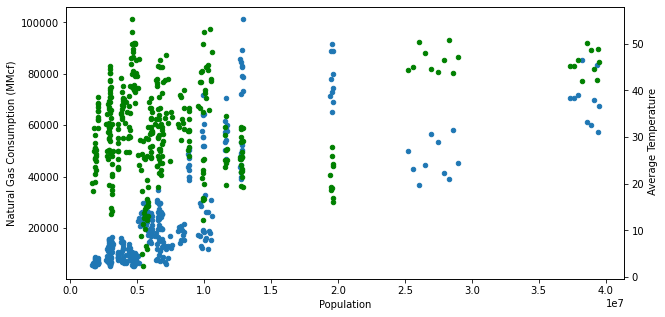

In [142]:
# ax1 = df1.plot()

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
# df2.plot(ax=ax2)

ax1 = combo_years.plot(kind='scatter', x='Population', y='Natural Gas Consumption (MMcf)', figsize=(10, 5))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
combo_years.plot(kind='scatter', ax=ax2, x='Population', y=' Average Temperature', color='green')

In [189]:
combo_years['Gas Usage Per Person (MMcf)'] = combo_years['Natural Gas Consumption (MMcf)'] / combo_years['Population']
combo_years['Gas Usage Per Person (MMcf)'] = combo_years['Gas Usage Per Person (MMcf)'].astype(float)

<AxesSubplot:xlabel='Population', ylabel='Gas Usage Per Person'>

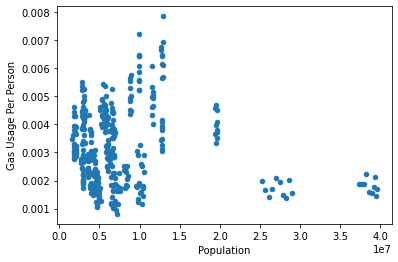

In [190]:
combo_years.plot(kind='scatter', x='Population', y='Gas Usage Per Person')

In [147]:
state_mean = combo_years.groupby('State').mean()

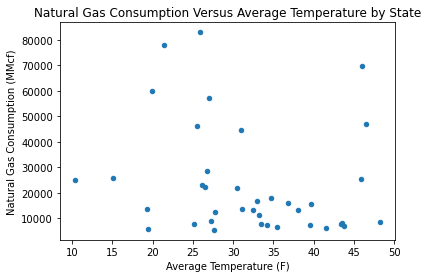

In [157]:
ax1 = state_mean.plot(kind='scatter', x=' Average Temperature', y='Natural Gas Consumption (MMcf)')
xlabel = ax1.set_xlabel('Average Temperature (F)')
title = ax1.set_title('Natural Gas Consumption Versus Average Temperature by State')

In [186]:
# function to plot linear regressions
def plotLinRegress(x, y, xlabel, ylabel, labelpos, title, image_name):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    print(f'The r-squared is: {rvalue**2}')
    regress_values = x * slope + intercept
    line_eq = f'y = {round(slope,2)}x + {round(intercept,2)}'
    
    plt.scatter(x,y)
    plt.plot(x, regress_values, "r-")
    plt.annotate(line_eq, labelpos, fontsize=15, color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'output_data/{image_name}.png')

The r-squared is: 0.04368908150550531


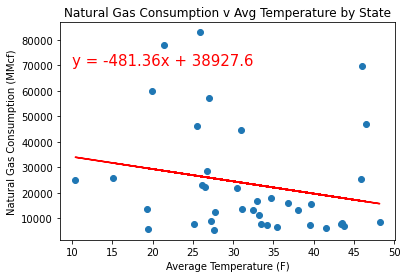

In [207]:
xlabel = 'Average Temperature (F)'
ylabel = 'Natural Gas Consumption (MMcf)'
title = 'Natural Gas Consumption v Avg Temperature by State'
labelpos = (10,70000)
image_name = 'gas_usage_v_temp_by_state'

plotLinRegress(state_mean[' Average Temperature'], state_mean['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos, title, image_name)

The r-squared is: 0.12020971358766926


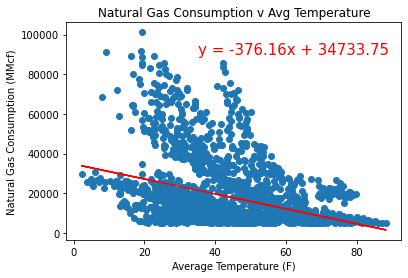

In [206]:
xlabel = 'Average Temperature (F)'
ylabel = 'Natural Gas Consumption (MMcf)'
labelpos = (35,90000)
title = 'Natural Gas Consumption v Avg Temperature'
image_name = 'gas_usage_v_temp_total'

plotLinRegress(combined_df[' Average Temperature'], combined_df['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos,title, image_name)

The r-squared is: 0.540475843476515


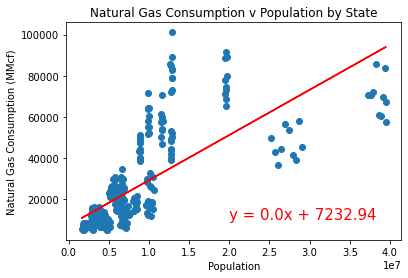

In [208]:
xlabel = 'Population'
ylabel = 'Natural Gas Consumption (MMcf)'
labelpos = (20000000, 10000)
title = 'Natural Gas Consumption v Population by State'
image_name = 'gas_usage_v_pop'

plotLinRegress(combo_years['Population'], combo_years['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos, title, image_name)

The r-squared is: 0.007751171256435762


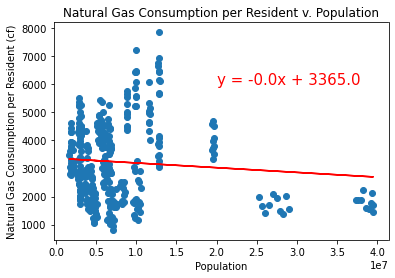

In [209]:
xlabel = 'Population'
ylabel = 'Natural Gas Consumption per Resident (cf)'
labelpos = (20000000, 6000)
title = 'Natural Gas Consumption per Resident v. Population'
image_name = 'gas_usage_per_person'
y = (combo_years['Gas Usage Per Person (MMcf)']) * 1000000 # changes unit from million cubic feet to just cubic feet
plotLinRegress(combo_years['Population'],y , xlabel, ylabel, labelpos, title, image_name)